In [53]:
using Plots
using Statistics
using Random

In [54]:
mutable struct IsingGrid
    Lx::Int64
    Ly::Int64
    grid::Array{Int64,2}
    energy::Int64
    function IsingGrid(Lx,Ly;periodic_bc=true)
        grid= rand([-1,1],Lx,Ly)
        if !periodic_bc
            grid[:,1]=ones(Ly)
            grid[:,end]=-ones(Ly)
        end
        energy= calculateGridEnergy(grid)
        return new(Lx,Ly,grid,energy)
    end
end;

In [55]:
function nearestNeighbors(x,y,Lx,Ly)
    right= ( mod(x,Lx) + 1, y)
    left= ( mod(x-2,Lx) + 1 ,y)
    up= (x,mod(y,Ly)+1)
    down= (x,mod(y-2,Ly)+1)
    return right,left,up,down
end;

In [56]:
function calculateGridEnergy(grid)
    Lx, Ly = size(grid)
    energy=0
    for x in range(1,Lx)
        for y in range(1,Ly)
            for neighbor in nearestNeighbors(x,y,Lx,Ly)
                energy-= grid[neighbor[1],neighbor[2]]*grid[x,y]
            end
        end
    end
    return energy/2
end;

In [71]:
function makeFlip!(state, T; periodic_bc=true)
    grid= state.grid
    Lx, Ly = size(grid)
    max_iterations=Lx*Ly
    bc_adjust= periodic_bc ? 0 : 1
    for i in range(1,max_iterations)
        x , y = rand(1:Lx), rand(1+bc_adjust:Ly-bc_adjust)
        energy_difference = 0
        for neighbor in nearestNeighbors(x,y,Lx,Ly)
            energy_difference+= grid[neighbor[1],neighbor[2]]*(2*grid[x,y])
        end
        if rand() < exp(-energy_difference/T)
            grid[x,y]*=-1
            state.energy+=energy_difference
            break
        end
    end
end;

In [59]:
function monte_carlo_anhealing!(model,maxT,minT,dT,num_of_flips; periodic_bc=true)
    energy_avgs_arr = []
    Cv_arr=[]
    dS_arr=[]
    for T in range(maxT,minT,step=-dT)
        if T==4.
            heatmap(model.grid,title="T=$T")
            if periodic_bc
                savefig("periodic_T$T.png")
            else
                savefig("bounded_T$T.png")
            end
        end
        energy_temp_arr = [model.energy]
        for i in range(1,num_of_flips)
            makeFlip!(model,T;periodic_bc=periodic_bc)
            append!(energy_temp_arr, model.energy)
        end
        energy_avg= sum(energy_temp_arr) / num_of_flips
        Cv=mean((energy_temp_arr.-energy_avg).^2)/(T^2)
        dS= -Cv*dT/T
        append!(dS_arr,dS)
        append!(Cv_arr,Cv)
        append!(energy_avgs_arr,energy_avg)
        if T in [3.,2.,1.,0.1]
            heatmap(model.grid,title="T=$T")
            if periodic_bc
                savefig("periodic_T$T.png")
            else
                savefig("bounded_T$T.png")
            end
        end
    end
    return energy_avgs_arr, Cv_arr, dS_arr
end;

In [60]:
Lx,Ly= 128, 128;
grid_periodic=IsingGrid(Lx,Ly);

In [73]:
grid_bound=IsingGrid(Lx,Ly,periodic_bc=false);

In [74]:
maxT=4.
minT=0.1
dT=0.01
num_of_flips=7000
T_array=  collect(range(4. ,0.1, step=-0.01));

Metropolis algorithm on periodic bc:

In [63]:
energy_avgs_arr_periodic, Cv_arr_periodic, dS_arr_periodic = monte_carlo_anhealing!(grid_periodic,maxT,minT,dT,num_of_flips);

In [64]:
relative_entropy_periodic = cumsum(dS_arr_periodic)
entropy_periodic= relative_entropy_periodic .- relative_entropy_periodic[end] .+ log(2)
free_energy_periodic = energy_avgs_arr_periodic .- (T_array .* entropy_periodic);

In [75]:
energy_avgs_arr_bound, Cv_arr_bound, dS_arr_bound = monte_carlo_anhealing!(grid_bound,maxT,minT,dT,num_of_flips; periodic_bc=false);

In [76]:
relative_entropy_bound = cumsum(dS_arr_bound)
entropy_bound= relative_entropy_bound .- relative_entropy_bound[end] .+ log(128)
free_energy_bound = energy_avgs_arr_bound .- (T_array .* entropy_bound);

Plotting the free energy vs temperature

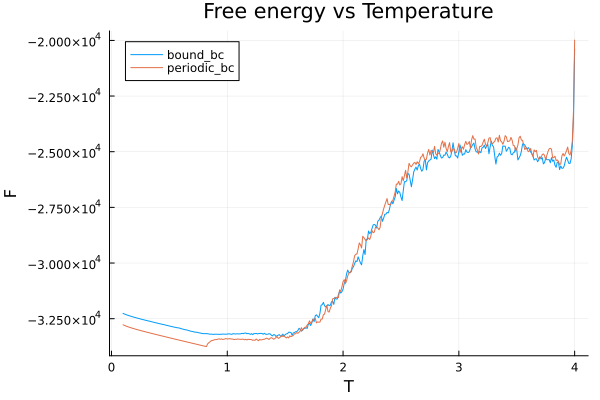

In [77]:
plot(T_array,free_energy_bound,title="Free energy vs Temperature", xlabel="T", ylabel="F",label="bound_bc")
plot!(T_array,free_energy_periodic,title="Free energy vs Temperature", xlabel="T", ylabel="F",label="periodic_bc")

Plotting entropy vs temperature

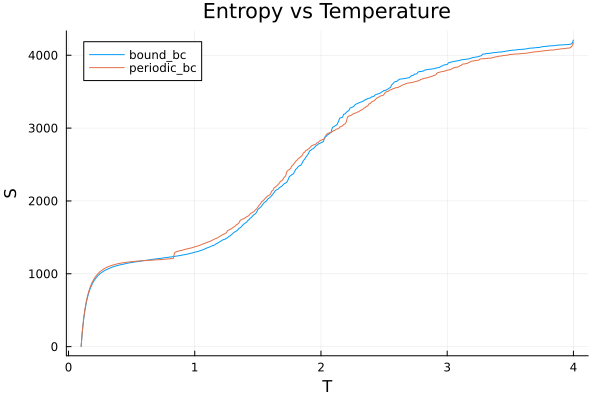

In [78]:
plot(T_array,entropy_bound,title="Entropy vs Temperature", xlabel="T", ylabel="S",label="bound_bc")
plot!(T_array,entropy_periodic,title="Entropy vs Temperature", xlabel="T", ylabel="S",label="periodic_bc")

Free energy difference between bound and periodic i.c

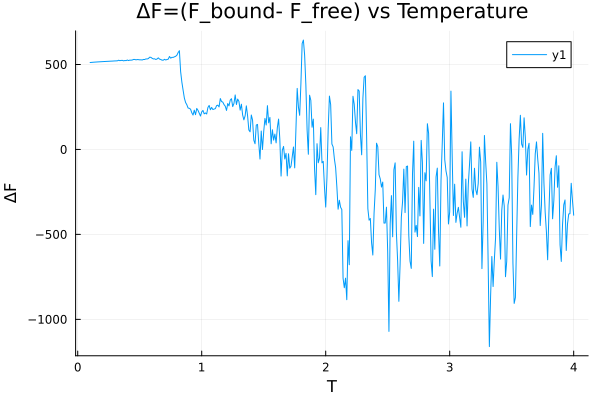

In [79]:
plot(T_array,free_energy_bound-free_energy_periodic, title = "ΔF=(F_bound- F_free) vs Temperature", xlabel="T",ylabel="ΔF")

In [81]:
(free_energy_bound-free_energy_periodic)[1]

-387.10647086496465

In [82]:
(free_energy_bound-free_energy_periodic)[end]

511.65725454880885